# Fine-tuning ResNet50

---

## 1. Load Tensors and Targets

In [2]:
import numpy as np
from common import *

train_ids, train_targets = load_dataset('data/preprocess/train.npz')
valid_ids, valid_targets = load_dataset('data/preprocess/valid.npz')
test_ids, test_targets = load_dataset('data/preprocess/test.npz')

train_files = np.array(['data/train_photos/' + str(i) + '.jpg' for i in train_ids])
valid_files = np.array(['data/train_photos/' + str(i) + '.jpg' for i in valid_ids])
test_files = np.array(['data/train_photos/' + str(i) + '.jpg' for i in test_ids])

del train_ids, valid_ids, test_ids

print('There are %d images in the training dataset' % len(train_files))
print('There are %d images in the validation dataset' % len(valid_files))
print('There are %d images in the test dataset' % len(test_files))

There are 176131 images in the training dataset
There are 29355 images in the validation dataset
There are 29356 images in the test dataset


In [3]:
from keras.applications.resnet50 import preprocess_input

nb_train, nb_valid, nb_test = (50000,5000,5000)

train_tensors = preprocess_input(paths_to_tensor(train_files[:nb_train]))
del train_files
valid_tensors = preprocess_input(paths_to_tensor(valid_files[:nb_valid]))
del valid_files
test_tensors = preprocess_input(paths_to_tensor(test_files[:nb_test]))
del test_files

100%|██████████| 5000/5000 [00:22<00:00, 226.22it/s]


## 2. Import the ResNet50 Deep Learning Model

In [4]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

for i, layer in enumerate(base_model.layers): print(i, layer.name)

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

In [5]:
for layer in base_model.layers: layer.trainable = False

## 3. Add New Layers

In [6]:
from keras.layers import Dropout, GlobalAveragePooling2D, Dense
from keras.models import Model

addon = base_model.output
addon = Dropout(0.75)(addon)
addon = GlobalAveragePooling2D()(addon)
addon = Dense(1024, activation='relu')(addon)
top = Dense(9, activation='sigmoid')(addon)

model = Model(inputs=base_model.input, outputs=top)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_tensors, train_targets[:nb_train], validation_data=(valid_tensors,valid_targets[:nb_valid]),
          epochs=5, batch_size=64, verbose=1)

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 106s 2ms/step - loss: 0.5673 - acc: 0.7047 - val_loss: 0.5186 - val_acc: 0.7310
Epoch 2/5
50000/50000 [==============================] - 102s 2ms/step - loss: 0.5352 - acc: 0.7218 - val_loss: 0.5123 - val_acc: 0.7366
Epoch 3/5
50000/50000 [==============================] - 102s 2ms/step - loss: 0.5289 - acc: 0.7273 - val_loss: 0.4984 - val_acc: 0.7490
Epoch 4/5
50000/50000 [==============================] - 102s 2ms/step - loss: 0.5255 - acc: 0.7301 - val_loss: 0.5049 - val_acc: 0.7439
Epoch 5/5
50000/50000 [==============================] - 102s 2ms/step - loss: 0.5203 - acc: 0.7343 - val_loss: 0.5072 - val_acc: 0.7382


## 4. Fine-tune Model

In [7]:
for layer in model.layers[:131]:
   layer.trainable = False
for layer in model.layers[131:]:
   layer.trainable = True

In [8]:
from keras.optimizers import SGD

sgd = SGD(lr=0.0001, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

checkpointer = ModelCheckpoint(filepath='data/saved_models/weights_finetune_resnet50.hdf5', save_best_only=True)
checkimprovement = EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
fit = History()

fit = model.fit(train_tensors, train_targets[:nb_train], validation_data=(valid_tensors, valid_targets[:nb_valid]), 
                epochs=300, batch_size=64, callbacks=[checkpointer,checkimprovement,fit])

Train on 50000 samples, validate on 5000 samples
Epoch 1/300
50000/50000 [==============================] - 125s 2ms/step - loss: 0.5159 - acc: 0.7365 - val_loss: 0.5012 - val_acc: 0.7516
Epoch 2/300
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5092 - acc: 0.7407 - val_loss: 0.4998 - val_acc: 0.7533
Epoch 3/300
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5076 - acc: 0.7413 - val_loss: 0.4988 - val_acc: 0.7542
Epoch 4/300
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5060 - acc: 0.7431 - val_loss: 0.4977 - val_acc: 0.7542
Epoch 5/300
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5028 - acc: 0.7447 - val_loss: 0.4966 - val_acc: 0.7551
Epoch 6/300
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5008 - acc: 0.7456 - val_loss: 0.4955 - val_acc: 0.7557
Epoch 7/300
50000/50000 [==============================] - 123s 2ms/step - loss: 0.5001 - acc: 0.7464 - val_loss: 0.4

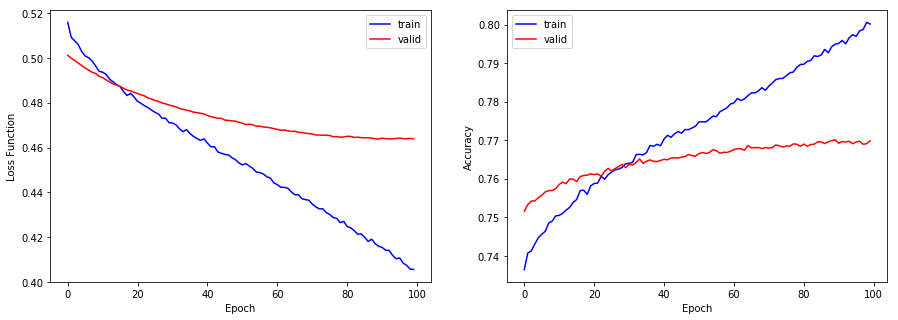

In [10]:
history(fit)

In [11]:
model.load_weights('data/saved_models/weights_finetune_resnet50.hdf5')

In [12]:
predictions = (model.predict(test_tensors) >= 0.5).astype(int)

In [13]:
model_score = f1_score(test_targets[:nb_test], predictions)
print('F1 score: %.5f' % model_score)

F1 score: 0.78466
